In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle

In [3]:
behavior_path = 'data/behaviors_new.tsv'
bias_detection_path = 'data/0929_concat_mind_over_res.csv'

In [4]:
behavior_df = pd.read_csv(behavior_path, sep='\t', header=None)
behavior_df.columns = ['idx', 'uid', 'date', 'history', 'impression']

In [5]:
behavior_df.head()

,idx,uid,date,history,impression
0,2,U231077,11/19/2019 5:28:08 AM,N45124 N84730 N45128 N104312 N70022 N99111 N26...,N14657 N51253 N49521 N126571 N74286 N101071 N1...
1,4,U320649,11/21/2019 6:03:51 AM,N110863 N7889 N86335 N85056 N115743 N63372 N19...,N119559 N37657 N108085 N91287 N39136 N130190 N...
2,7,U593249,11/21/2019 10:26:28 AM,N130269 N110630 N127780 N103724 N88400 N57296 ...,N40488 N69116 N47516
3,9,U394469,11/18/2019 9:21:22 AM,N58992 N109724 N79285 N53198 N121550 N28461 N5...,N55737 N31058 N21387 N111735 N78312 N60321 N12...
4,14,U44514,11/19/2019 11:45:01 AM,N60061 N124453 N95072 N90578 N80545 N16463 N36...,N2296 N62785 N15647 N16531 N101071 N54103 N646...


In [16]:
bias_detection_df = pd.read_csv(bias_detection_path, header=None, sep='\t')
bias_detection_df.columns = ['nid', 'category', 'sub_category', 'bias_prob']
print(bias_detection_df.shape)
bias_detection_df.head()

(122137, 4)

### Step 1: the number of behaviors after filtering historical articles without body content

In [6]:
!wc -l $behavior_path

  334742 data/behaviors_new.tsv


### Step 2: length distribution count

In [7]:
len2num = defaultdict(int)
for idx, row in behavior_df.iterrows():
    len2num[len(row['history'].split())] += 1

<BarContainer object of 194 artists>

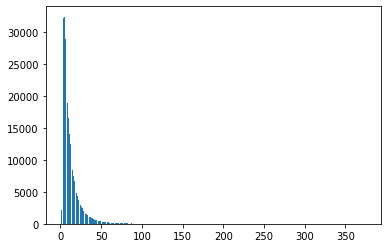

In [8]:
plt.bar(len2num.keys(), len2num.values())

In [9]:
behavior_df.shape

(334742, 5)

### Step 3:  Filter some browsing records that are too short

In [10]:
def filter_by_length(history, min_len=5):
    if len(history.split()) < min_len:
        return False
    else:
        return True

In [11]:
len_indice = behavior_df.apply(lambda x: filter_by_length(x['history'], min_len=5), axis=1)

In [12]:
behavior_df = behavior_df[len_indice]

In [13]:
behavior_df.shape

(280462, 5)

### Step 4: calculate bias proportion for each user

In [18]:
nid2prob = dict(zip(bias_detection_df['nid'], bias_detection_df['bias_prob']))

In [19]:
len(nid2prob)

122137

In [20]:

# uid, num_unbiased, num_biased, num_unknown, unbiased_nid_list, biased_nid_list

def get_user_info(user_group, news_bias_path):
    empty_uids = []
    num_miss_uid = 0
    uid_list = []
    num_unbiased_list = []
    num_biased_list = []
    num_unknown_list = []
    num_total_list = []
    total_nid_unbiased_list = []
    total_nid_biased_list = []
    total_nid_unknown_list = []
    
    news_bias_df = pd.read_csv(news_bias_path, sep="\t", header=None)
    news_bias_df.columns = ['nid', 'category', 'sub_category', 'bias_prob']
    nid2category = news_bias_df.set_index('nid').to_dict()['category']
    nid2sub_category = news_bias_df.set_index('nid').to_dict()['sub_category']
    nid2bias_prob = news_bias_df.set_index('nid').to_dict()['bias_prob']
    
    for uid, grouped in user_group:
        
        try:
            num_unbiased = 0
            num_biased = 0
            num_unknown = 0
            nid_biased_list = []
            nid_unbiased_list = []
            nid_unknown_list = []
            
            nid_history_list = grouped.iloc[0]["history"].split(" ")
            for nid in nid_history_list:
                if nid in nid2bias_prob:
                    if nid2bias_prob[nid] >= 0.5:
                        num_biased += 1
                        nid_biased_list.append(nid)
                    else:
                        num_unbiased += 1
                        nid_unbiased_list.append(nid)
                else:
                    num_unknown += 1
                    nid_unknown_list.append(nid)
            
            uid_list.append(uid)
            num_unbiased_list.append(num_unbiased)
            num_biased_list.append(num_biased)
            num_unknown_list.append(num_unknown)
            num_total_list.append(len(nid_history_list))
            total_nid_unbiased_list.append(nid_unbiased_list)
            total_nid_biased_list.append(nid_biased_list)
            total_nid_unknown_list.append(nid_unknown_list)
        except:
            empty_uids.append(uid)
            num_miss_uid += 1
            
    assert len(empty_uids) == num_miss_uid
    user_info_df = pd.DataFrame(
        {'uid': uid_list,
         'num_unbiased': num_unbiased_list,
         'num_biased': num_biased_list,
         'num_unknown': num_unknown_list,
         'num_total': num_total_list,
         'total_nid_unbiased': total_nid_unbiased_list,
         'total_nid_biased': total_nid_biased_list,
         'total_nid_unknown': total_nid_unknown_list,
        }
    )
    
    return user_info_df, empty_uids





In [21]:
user_group = behavior_df.groupby('uid')

In [22]:
user_info_df, empty_uids = get_user_info(user_group=user_group, 
                                         news_bias_path=bias_detection_path)

In [23]:
empty_uids

[]

In [24]:
user_info_df.head()

,uid,num_unbiased,num_biased,num_unknown,num_total,total_nid_unbiased,total_nid_biased,total_nid_unknown
0,U1000,9,2,0,11,"[N20131, N65823, N65823, N111503, N3992, N1047...","[N33446, N70022]",[]
1,U100008,8,1,0,9,"[N85167, N124096, N72980, N6120, N14320, N1196...",[N46329],[]
2,U100016,8,4,0,12,"[N80883, N124796, N89166, N99279, N107732, N70...","[N20915, N79214, N29936, N29044]",[]
3,U100019,16,1,0,17,"[N55903, N98238, N109468, N29748, N123353, N73...",[N126000],[]
4,U100020,5,0,0,5,"[N119718, N126611, N127629, N3664, N93856]",[],[]


In [22]:
user_info_df.head()

,uid,num_unbiased,num_biased,num_unknown,num_total,total_nid_unbiased,total_nid_biased,total_nid_unknown
0,U1000,9,2,0,11,"[N20131, N65823, N65823, N111503, N3992, N1047...","[N33446, N70022]",[]
1,U100008,8,1,0,9,"[N85167, N124096, N72980, N6120, N14320, N1196...",[N46329],[]
2,U100016,8,4,0,12,"[N80883, N124796, N89166, N99279, N107732, N70...","[N20915, N79214, N29936, N29044]",[]
3,U100019,16,1,0,17,"[N55903, N98238, N109468, N29748, N123353, N73...",[N126000],[]
4,U100020,5,0,0,5,"[N119718, N126611, N127629, N3664, N93856]",[],[]


In [25]:
user_info_df['bias_prop'] = user_info_df['num_biased'] / user_info_df['num_total']

In [26]:
user_info_df.head()

,uid,num_unbiased,num_biased,num_unknown,num_total,total_nid_unbiased,total_nid_biased,total_nid_unknown,bias_prop
0,U1000,9,2,0,11,"[N20131, N65823, N65823, N111503, N3992, N1047...","[N33446, N70022]",[],0.181818
1,U100008,8,1,0,9,"[N85167, N124096, N72980, N6120, N14320, N1196...",[N46329],[],0.111111
2,U100016,8,4,0,12,"[N80883, N124796, N89166, N99279, N107732, N70...","[N20915, N79214, N29936, N29044]",[],0.333333
3,U100019,16,1,0,17,"[N55903, N98238, N109468, N29748, N123353, N73...",[N126000],[],0.058824
4,U100020,5,0,0,5,"[N119718, N126611, N127629, N3664, N93856]",[],[],0.000000


In [28]:
user_info_df_1 = user_info_df.loc[(user_info_df['bias_prop'] > 0.0) & (user_info_df['bias_prop'] < 0.1)]  # too many 0 shaould be consided
user_info_df_2 = user_info_df.loc[(user_info_df['bias_prop'] >= 0.1) & (user_info_df['bias_prop'] < 0.2)] 
user_info_df_3 = user_info_df.loc[(user_info_df['bias_prop'] >= 0.2) & (user_info_df['bias_prop'] < 0.3)] 
user_info_df_4 = user_info_df.loc[(user_info_df['bias_prop'] >= 0.3) & (user_info_df['bias_prop'] < 0.4)] 
user_info_df_5 = user_info_df.loc[(user_info_df['bias_prop'] >= 0.4)] 

In [29]:
user_info_df_1.shape, user_info_df_2.shape, user_info_df_3.shape, user_info_df_4.shape, user_info_df_5.shape

((43149, 9), (82000, 9), (44965, 9), (14248, 9), (10776, 9))

### Step 5. Count the number of users in each interval

In [32]:

intervals = {
    '(0%~10%)': user_info_df_1.shape[0],
    '[10%~20%)': user_info_df_2.shape[0],
    '[20%~30%)': user_info_df_3.shape[0],
    '[30%~40%)': user_info_df_4.shape[0],
    '[40%~100%]': user_info_df_5.shape[0],
}


In [33]:
# the number of users in each group
intervals


# {'(0%~10%)': 43149,
#  '[10%~20%)': 82000,
#  '[20%~30%)': 44965,
#  '[30%~40%)': 14248,
#  '[40%~100%]': 10776}

{'(0%~10%)': 43149,
 '[10%~20%)': 82000,
 '[20%~30%)': 44965,
 '[30%~40%)': 14248,
 '[40%~100%]': 10776}

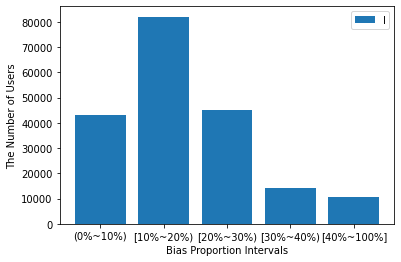

In [34]:


plt.bar(intervals.keys(), intervals.values())
plt.xlabel('Bias Proportion Intervals')
plt.ylabel('The Number of Users')
plt.legend('loc=upper right')
plt.savefig(f'data/user_biasprop_distribution.png')

In [35]:
intervals = {
    '0.0~0.1': user_info_df_1.shape[0],
    '0.1~0.2': user_info_df_2.shape[0],
    '0.2~0.3': user_info_df_3.shape[0],
    '0.3~0.4': user_info_df_4.shape[0],
    '0.4~0.5': user_info_df_5.shape[0],
}

In [36]:
intervals

{'0.0~0.1': 43149,
 '0.1~0.2': 82000,
 '0.2~0.3': 44965,
 '0.3~0.4': 14248,
 '0.4~0.5': 10776}

<BarContainer object of 5 artists>

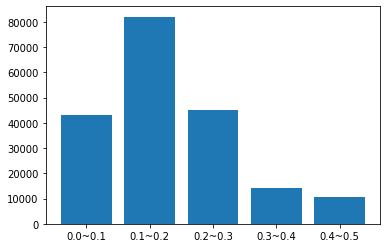

In [37]:
plt.bar(intervals.keys(), intervals.values())


### Step 6. random sample n from each interval

In [38]:
num_sample = 2000

In [39]:
user_info_df_1 = user_info_df_1.sample(n=num_sample, random_state=2022)
user_info_df_2 = user_info_df_2.sample(n=num_sample, random_state=2022)
user_info_df_3 = user_info_df_3.sample(n=num_sample, random_state=2022)
user_info_df_4 = user_info_df_4.sample(n=num_sample, random_state=2022)
user_info_df_5 = user_info_df_5.sample(n=num_sample, random_state=2022)

In [40]:
user_info_df_1.shape

(2000, 9)

In [41]:
user_info_df_5['bias_prop'].mean()

0.4715652631304113

In [42]:
user_info_df_4['bias_prop'].mean()

0.3358246675705566

In [43]:
user_info_df_3['bias_prop'].mean()

0.2306141069167364

In [44]:
user_info_df_2['bias_prop'].mean()

0.139937218405384

In [45]:
user_info_df_1['bias_prop'].mean()

0.06918186697908019

### 保存userid

In [46]:
user_info_dict_2000 = {
    '1': user_info_df_1,
    '2': user_info_df_2,
    '3': user_info_df_3,
    '4': user_info_df_4,
    '5': user_info_df_5,
}

In [47]:
with open('data/user_info_dict_2000.pkl', "wb") as f:
    pickle.dump(user_info_dict_2000, f)